In [123]:
from models.FC_models import *

## helpers

In [144]:
import numpy as np

def imsave(img, name, path, saving_path=None):
    img = img / 2 + 0.5     # unnormalize
    #saving_path = os.path.join(args.output_path, name+'.png')
    print(f"saving to {saving_path }")
    torchvision.utils.save_image(img, saving_path)

def imshow(img, name, ax=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    if ax:
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


In [141]:
PATCH_SIZE = 8

model_path = "saved_models/mikmik_fc_res-p8_b16-1_100.pkl"
model = Residual2CoreFC(coded_size=16,
                        patch_size=PATCH_SIZE,
                        num_passes=4)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# training dataset

In [142]:
import torchvision
import torchvision.transforms as transforms

# Normalize function so given an image of range [0, 1] transforms it into a Tensor range [-1. 1]
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR LOADER
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)

dataiter = iter(train_loader)

Files already downloaded and verified


# produce reconstructed images

In [143]:
from evaluation import to_patches, reconstruct_patches

imgs, labels = next(dataiter)
print(labels[0])

#
def reconstruct(imgs, model = model):
    # break to patches
    patches = to_patches(imgs, PATCH_SIZE)
    r_patches = [model.sample(p) for p in patches] # pass all the patches
    reconstructed = reconstruct_patches(r_patches)

    return reconstructed

reconstructed = reconstruct(imgs,model)

tensor(82)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


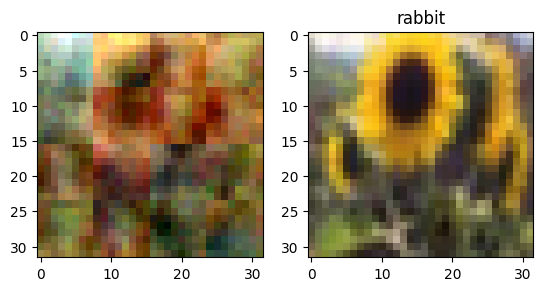

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [145]:
import matplotlib.pyplot as plt

# show image alongside original
f, axarr = plt.subplots(1, 2)
plt.title(classes[labels[0]])
imshow(reconstructed[0], "reconstructed", ax=axarr[0])
imshow(imgs[0], "original", ax=axarr[1])

# Classifier

In [130]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
from PIL import Image

In [131]:
classifier = torchvision.models.resnet18(num_classes=1000, weights=torchvision.models.ResNet18_Weights.DEFAULT)

In [132]:
import torch.nn as nn

device = "cpu"
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.conv5 = conv_block(512, 1028, pool=True)
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))

        self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1028 x 1 x 1
                                        nn.Flatten(), # 1028
                                        nn.Linear(1028, num_classes)) # 1028 -> 100

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

classifier = to_device(ResNet9(3, 100), device)
classifier

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [133]:
# Initialize the model
#model = resnet100(pretrained=False)  # Set pretrained=False since we are loading custom weights

# Update this number of output features to match the CIFAR-100 classes if not using ResNet50 directly or the model has been modified
#model.fc = torch.nn.Linear(model.fc.in_features, 100)  # CIFAR-100 has 100 classes

# Load the weights
classifier.load_state_dict(torch.load('classifiers/group22_pretrained_model.h5',map_location=torch.device('cpu')))

# Set the model to evaluation mode
classifier.eval()

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

tensor(62)
predict from origin: 54


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted from reconstruction: 25


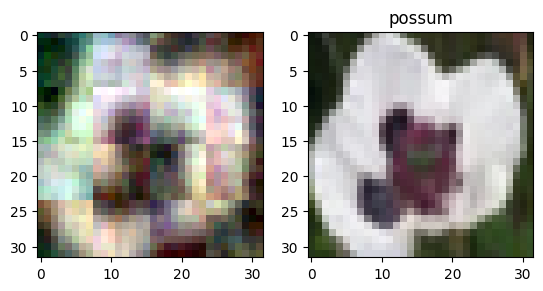

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [169]:
imgs1, labels = next(dataiter)
print(labels[0])
print(f"predict from origin: {classifier(imgs1).argmax()}")

reconstructed = reconstruct(imgs1,model)
print(f"predicted from reconstruction: {classifier(reconstructed).argmax()}")

# show image alongside original
f, axarr = plt.subplots(1, 2)
plt.title(classes[labels[0]])
imshow(reconstructed[0], "reconstructed", ax=axarr[0])
imshow(imgs1[0], "original", ax=axarr[1])
